## 1. Set-up
Install, import, helper functions, including dataloaders and processing functions.


In [1]:
# mounts your Google Drive to the Colab runtime environment
# and change the current working directory to your source to access custom modules

import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
working_dir = '/content/drive/MyDrive/capstone/BioCV_Su23/src'
os.chdir(working_dir)

Mounted at /content/drive


### 1.1 installation

In [2]:
!pip install onedrivedownloader nibabel

### 1.2 imports

In [38]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import random
from tqdm.auto import tqdm

from onedrivedownloader import download

# Custom modules
import utils.mri_common as mri_common
import utils.data_handler as dh
import importlib
importlib.reload(dh)
importlib.reload(mri_common)

import utils.mri_common as mri_common
from utils.data_handler import DataHandler, StructuralScan, MriType
from utils.mri_plotter import MRIPlotter
from utils.mri_common import get_zero_reduction_dimensions, get_mri_subj, normalize_and_save, copy_segm_files,\
    reduce_data, split_subjects, collate_scans, get_data_stats, plot_scan_stats, normalize_collated_data, \
    update_collated_stats, generate_2d_slices
from utils.mri_common import SliceDirection
# Initializations
np.set_printoptions(precision=16)

# Initialize data handler
data_handler = DataHandler()
mri_plt = MRIPlotter()

In [4]:
# seeding
random.seed(100)
np.random.seed(100)

## Pre-processing methods

### 2.1 Zero-data-removal

In [6]:
# download and list pre-operative structural scans for zero-reduction operation
# note that calling list_mri_in_dir will automatically download the files from OneDrive to the colab runtime environment
struct_files, struct_files_dir = data_handler.list_mri_in_dir(mri_type=MriType.STRUCT_SCAN, return_dir=True)
print("structural scan directory", struct_files_dir)

mri directory /content/data/images_structural
structural scan directory /content/data/images_structural


In [7]:
# save a list of all structural scan types
struct_scans = [scan.value for scan in StructuralScan]
print("scan types:", struct_scans)


scan types: ['FLAIR', 'T1', 'T1GD', 'T2']


In [8]:
# save a list of all unique patients from those that are manually annotated
segm_files, segm_dir = data_handler.list_mri_in_dir(mri_type=MriType.ANNOTATED, return_dir=True)
subjects = list(set([get_mri_subj(filename) for filename in segm_files]))
subjects.sort()

n_sample = len(subjects)
print("annotated files", n_sample)
print("first five subjs", subjects[:5])
print("annotated files dir", segm_dir)

mri directory /content/data/images_segm
annotated files 147
first five subjs ['UPENN-GBM-00002', 'UPENN-GBM-00006', 'UPENN-GBM-00008', 'UPENN-GBM-00009', 'UPENN-GBM-00011']
annotated files dir /content/data/images_segm


In [9]:
# call get_zero_reduction_dimensions to get reduced dimensions.
new_dim = get_zero_reduction_dimensions(mri_dir=struct_files_dir, subj_list=subjects, struct_scan_list=struct_scans)

min idx in height is: 37 max idx in height is: 200
min idx in width is : 30 max idx in width is : 223
min idx in depth is : 0 max idx in depth is : 146
Original height / width / depth : 240 / 240 / 155
     New height / width / depth : 164 / 194 / 147
Data reduction : 47.61 %


### 2.2 Reduce data and save structure MRI with annotations

In [10]:
# use the google colab runtime environment
DATA_DIR = data_handler.data_dir
print("workspace data directory:", DATA_DIR)

workspace data directory: /content/data


In [18]:
# create a new folder, save all reduced data into the new folder
output_dir = os.path.join(DATA_DIR, 'images_annot_reduced')

reduce_data(new_dim=new_dim, subj_list=subjects,
            struct_scans=struct_scans, struct_scan_dir=struct_files_dir,
            segm_dir=segm_dir, output_dir=output_dir)

Dimension of Image are height: 163 width: 193 depth: 146


In [ ]:
# note that this will download the zip file relative to the working directory
# and not into the colab runtime environment

# somehow, we cannot download the .zip when saving to the runtime probably due to the file size
# after creating the zip file, upload to one drive

temp_file_path = os.path.join(os.getcwd(), "temp_files")
if not os.path.exists(temp_file_path):
    os.makedirs(temp_file_path)
zip_file = os.path.join(temp_file_path, "images_annot_reduced.zip")

!cd $output_dir && zip -rq $zip_file *

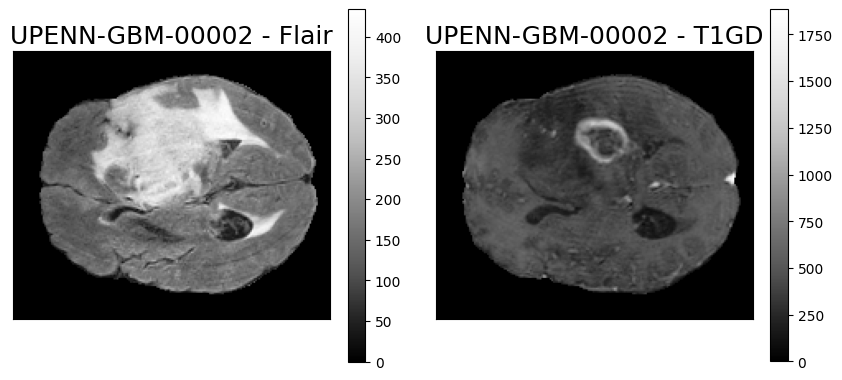

In [20]:
# qc sample images
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

test_img = "UPENN-GBM-00002"
flair_img = data_handler.load_mri(subj_id=test_img, mri_type=MriType.STRUCT_SCAN_REDUCED, struct_scan=StructuralScan.FLAIR)
t1gd_img = data_handler.load_mri(subj_id=test_img, mri_type=MriType.STRUCT_SCAN_REDUCED, struct_scan=StructuralScan.T1GD)

mri_plt.plot_struct_img(img_data=flair_img, fig=fig, axs=axs, row=0, col=0, title=f"{test_img} - Flair")
mri_plt.plot_struct_img(img_data=t1gd_img, fig=fig, axs=axs, row=0, col=1, title=f"{test_img} - T1GD")
plt.show()

### 2.3 QC 3D cube statistics and normalization test

In [21]:
# this part will work without running the previous steps if the zip file for the reduced images have already been uploaded to OneDrive
# a onedrive link is also added to the data_handler to recognize this new image type
reduced_files, reduced_dir = data_handler.list_mri_in_dir(mri_type=MriType.STRUCT_SCAN_REDUCED, return_dir=True)
print("Reduced Files Dir", reduced_dir)

sliced_data = data_handler.load_mri(subj_id=subjects[0], mri_type=MriType.STRUCT_SCAN_REDUCED, struct_scan=StructuralScan.FLAIR)
print(f"Shape of reduced-flair for {subjects[0]}:", sliced_data.shape)

mri directory /content/data/images_annot_reduced
Reduced Files Dir /content/data/images_annot_reduced
Shape of reduced-flair for UPENN-GBM-00002: (163, 193, 146)


In [22]:
# collate all the images together into a single array
# note: this is memory intensive so use the High-Memory runtime
collated_img = collate_scans(
    subject_list=subjects,
    shape=sliced_data.shape,
    struct_scan_list=struct_scans,
    data_path=reduced_dir
)

Working on subject no: 1 / 147
Working on subject no: 2 / 147
Working on subject no: 3 / 147
Working on subject no: 4 / 147
Working on subject no: 5 / 147
Working on subject no: 6 / 147
Working on subject no: 7 / 147
Working on subject no: 8 / 147
Working on subject no: 9 / 147
Working on subject no: 10 / 147
Working on subject no: 11 / 147
Working on subject no: 12 / 147
Working on subject no: 13 / 147
Working on subject no: 14 / 147
Working on subject no: 15 / 147
Working on subject no: 16 / 147
Working on subject no: 17 / 147
Working on subject no: 18 / 147
Working on subject no: 19 / 147
Working on subject no: 20 / 147
Working on subject no: 21 / 147
Working on subject no: 22 / 147
Working on subject no: 23 / 147
Working on subject no: 24 / 147
Working on subject no: 25 / 147
Working on subject no: 26 / 147
Working on subject no: 27 / 147
Working on subject no: 28 / 147
Working on subject no: 29 / 147
Working on subject no: 30 / 147
Working on subject no: 31 / 147
Working on subjec

In [23]:
# calculate raw stats
raw_stats_arr = get_data_stats(
    subject_list=subjects,
    struct_scan_list=struct_scans,
    data_path=reduced_dir
)

Working on Subject No: 1 / 147
Working on Subject No: 2 / 147
Working on Subject No: 3 / 147
Working on Subject No: 4 / 147
Working on Subject No: 5 / 147
Working on Subject No: 6 / 147
Working on Subject No: 7 / 147
Working on Subject No: 8 / 147
Working on Subject No: 9 / 147
Working on Subject No: 10 / 147
Working on Subject No: 11 / 147
Working on Subject No: 12 / 147
Working on Subject No: 13 / 147
Working on Subject No: 14 / 147
Working on Subject No: 15 / 147
Working on Subject No: 16 / 147
Working on Subject No: 17 / 147
Working on Subject No: 18 / 147
Working on Subject No: 19 / 147
Working on Subject No: 20 / 147
Working on Subject No: 21 / 147
Working on Subject No: 22 / 147
Working on Subject No: 23 / 147
Working on Subject No: 24 / 147
Working on Subject No: 25 / 147
Working on Subject No: 26 / 147
Working on Subject No: 27 / 147
Working on Subject No: 28 / 147
Working on Subject No: 29 / 147
Working on Subject No: 30 / 147
Working on Subject No: 31 / 147
Working on Subjec

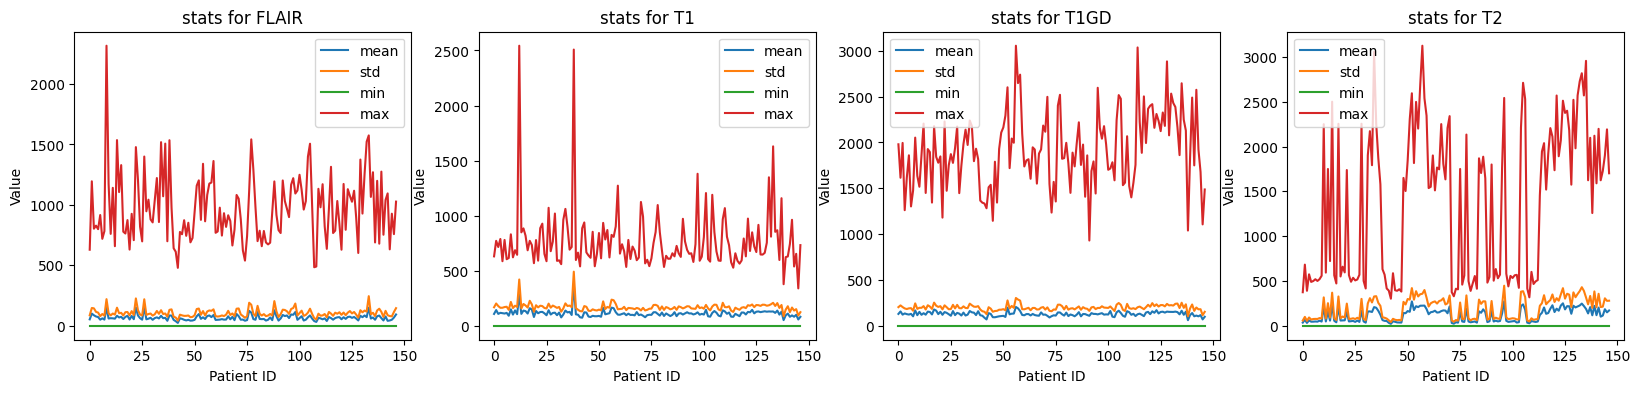

In [24]:
plot_scan_stats(
    raw_stats_arr,
    struct_scans,
)

In [25]:
# what is the min of the mins?
raw_stats_arr[:, :, 2].min()

0.0

In [26]:
# normalize the collated images
normalize_collated_data(
    collated_img,
    raw_stats_arr,
    subjects,
    struct_scans
)

Working on Subject No: 1 / 147
Working on Subject No: 2 / 147
Working on Subject No: 3 / 147
Working on Subject No: 4 / 147
Working on Subject No: 5 / 147
Working on Subject No: 6 / 147
Working on Subject No: 7 / 147
Working on Subject No: 8 / 147
Working on Subject No: 9 / 147
Working on Subject No: 10 / 147
Working on Subject No: 11 / 147
Working on Subject No: 12 / 147
Working on Subject No: 13 / 147
Working on Subject No: 14 / 147
Working on Subject No: 15 / 147
Working on Subject No: 16 / 147
Working on Subject No: 17 / 147
Working on Subject No: 18 / 147
Working on Subject No: 19 / 147
Working on Subject No: 20 / 147
Working on Subject No: 21 / 147
Working on Subject No: 22 / 147
Working on Subject No: 23 / 147
Working on Subject No: 24 / 147
Working on Subject No: 25 / 147
Working on Subject No: 26 / 147
Working on Subject No: 27 / 147
Working on Subject No: 28 / 147
Working on Subject No: 29 / 147
Working on Subject No: 30 / 147
Working on Subject No: 31 / 147
Working on Subjec

In [27]:
# calculate new stats and plot
updated_stats_arr = update_collated_stats(
    collated_img,
    subjects,
    struct_scans
)

Working on Subject No: 1 / 147
Working on Subject No: 2 / 147
Working on Subject No: 3 / 147
Working on Subject No: 4 / 147
Working on Subject No: 5 / 147
Working on Subject No: 6 / 147
Working on Subject No: 7 / 147
Working on Subject No: 8 / 147
Working on Subject No: 9 / 147
Working on Subject No: 10 / 147
Working on Subject No: 11 / 147
Working on Subject No: 12 / 147
Working on Subject No: 13 / 147
Working on Subject No: 14 / 147
Working on Subject No: 15 / 147
Working on Subject No: 16 / 147
Working on Subject No: 17 / 147
Working on Subject No: 18 / 147
Working on Subject No: 19 / 147
Working on Subject No: 20 / 147
Working on Subject No: 21 / 147
Working on Subject No: 22 / 147
Working on Subject No: 23 / 147
Working on Subject No: 24 / 147
Working on Subject No: 25 / 147
Working on Subject No: 26 / 147
Working on Subject No: 27 / 147
Working on Subject No: 28 / 147
Working on Subject No: 29 / 147
Working on Subject No: 30 / 147
Working on Subject No: 31 / 147
Working on Subjec

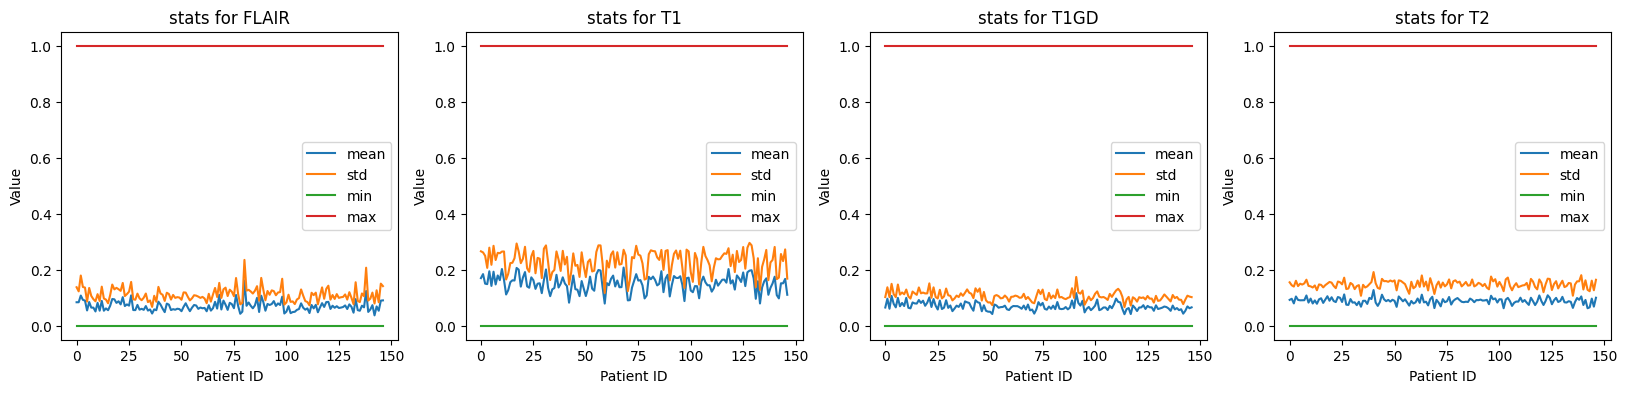

In [28]:
# plot new statistics
plot_scan_stats(
    updated_stats_arr,
    struct_scans
)

### 2.4 Split reduced struct versions into Train, Val, Test

In [29]:
train_list, reserve_list = split_subjects(subjects, split_ratio=0.6, seed=2023)
val_list, test_list = split_subjects(reserve_list, split_ratio=0.5, seed=2023)

# QC
print(len(train_list))
print(len(val_list))
print(len(test_list))
print(len(subjects) == (len(train_list) + len(val_list) + len(test_list)))

88
30
29
True


### 2.5 Normalize and Output 3D cubes

In [30]:
print("verify reduced dir", reduced_dir)

verify reduced dir /content/data/images_annot_reduced


In [31]:
output_dir = os.path.join(DATA_DIR, "images_annot_reduced_norm")

normalize_and_save(
    subjects_list=subjects,
    struct_scan_list=struct_scans,
    data_dir=reduced_dir,
    output_dir=output_dir,
    train_list=train_list,
    val_list=val_list,
    test_list=test_list
)

Working on subject no: 1 / 147
Working on subject no: 2 / 147
Working on subject no: 3 / 147
Working on subject no: 4 / 147
Working on subject no: 5 / 147
Working on subject no: 6 / 147
Working on subject no: 7 / 147
Working on subject no: 8 / 147
Working on subject no: 9 / 147
Working on subject no: 10 / 147
Working on subject no: 11 / 147
Working on subject no: 12 / 147
Working on subject no: 13 / 147
Working on subject no: 14 / 147
Working on subject no: 15 / 147
Working on subject no: 16 / 147
Working on subject no: 17 / 147
Working on subject no: 18 / 147
Working on subject no: 19 / 147
Working on subject no: 20 / 147
Working on subject no: 21 / 147
Working on subject no: 22 / 147
Working on subject no: 23 / 147
Working on subject no: 24 / 147
Working on subject no: 25 / 147
Working on subject no: 26 / 147
Working on subject no: 27 / 147
Working on subject no: 28 / 147
Working on subject no: 29 / 147
Working on subject no: 30 / 147
Working on subject no: 31 / 147
Working on subjec

#### Add the associated SEGM files from the reduced files dir to the latent space vectors dir

In [32]:
# copy the associated SEGM annotation masks into OUTPUT_DIR
copy_segm_files(
    output_dir,
    reduced_dir,
    subjects,
    train_list,
    val_list,
    test_list
)

#### Zip the files together and download


In [33]:
print("verify output directory", output_dir)

verify output directory /content/data/images_annot_reduced_norm


In [ ]:
# do not save in runtime colab. save in the current working directory instead
zip_file = os.path.join(os.getcwd(), "temp_files", "images_annot_reduced_norm.zip")
zip_file

!cd $output_dir && zip -rq $zip_file *

#### QC normalized data

In [6]:
norm_imgs, norm_dir = data_handler.list_mri_in_dir(mri_type=MriType.ANNOTATED_REDUCED_NORM, return_dir=True)
norm_dir

mri directory /content/data/images_annot_reduced_norm


'/content/data/images_annot_reduced_norm'

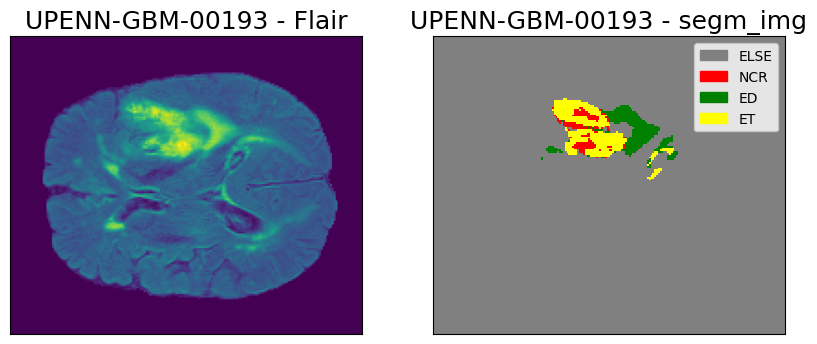

In [7]:
# qc sample images
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

test_img = "UPENN-GBM-00193"
flair_img = data_handler.load_mri(subj_id=test_img, mri_type=MriType.ANNOTATED_REDUCED_NORM, struct_scan=StructuralScan.FLAIR, dataset_type="test")
segm_img = data_handler.load_mri(subj_id=test_img, mri_type=MriType.ANNOTATED_REDUCED_NORM, dataset_type="test")

slice_idx = mri_common.get_largest_tumor_slice_idx(flair_img)[0]

mri_plt.plot_img(img_data=flair_img[:, :, slice_idx], fig=fig, axs=axs, row=0, col=0, title=f"{test_img} - Flair")
mri_plt.plot_segm_img(img_data=segm_img[:, :, slice_idx], fig=fig, axs=axs, row=0, col=1, title=f"{test_img} - segm_img", use_legend=True)
plt.show()

### 2.7 Create 2D data from 3D data

#### depth train and val

In [66]:
# import importlib
# import utils.mri_common as mri_common
# import utils.data_handler as df
# importlib.reload(mri_common)
# importlib.reload(df)
# import utils.mri_common as mri_common
# from utils.data_handler import DataHandler, StructuralScan, MriType
# data_handler = DataHandler()

In [16]:
# define output directory for 3d slices
data_dir = data_handler.data_dir
output_dir = os.path.join(data_dir, "images_annot_reduced_norm_2d")
print("output directory:", output_dir)

output directory: /content/data/images_annot_reduced_norm_2d


In [22]:
import shutil
# Delete the directory
shutil.rmtree(output_dir)

In [23]:
# extract DEPTH 2d slices from each 3d volume
data_dir_train_depth, data_dir_val_depth, data_dir_test_depth = generate_2d_slices(
    input_dir=norm_dir,
    output_dir=output_dir,
    orientation=SliceDirection.DEPTH
)

loaded_3d_mri_dir_train /content/data/images_annot_reduced_norm/train
loaded_3d_mri_dir_val /content/data/images_annot_reduced_norm/val
loaded_3d_mri_dir_test /content/data/images_annot_reduced_norm/test
Extracting 2D slices from 3D volumes (now is a good time to take a 15 min coffee break ...)


  0%|          | 0/3 [00:00<?, ?it/s]

Working on /content/data/images_annot_reduced_norm/train --> /content/data/images_annot_reduced_norm_2d/train/depth


  0%|          | 0/440 [00:00<?, ?it/s]

Working on /content/data/images_annot_reduced_norm/val --> /content/data/images_annot_reduced_norm_2d/val/depth


  0%|          | 0/150 [00:00<?, ?it/s]

Working on /content/data/images_annot_reduced_norm/test --> /content/data/images_annot_reduced_norm_2d/test/depth


  0%|          | 0/145 [00:00<?, ?it/s]

In [29]:
# extract CROSS_SIDE 2d slices from each 3d volume
data_dir_train_cross_side, data_dir_val_cross_side, data_dir_test_cross_side = generate_2d_slices(
    input_dir=norm_dir,
    output_dir=output_dir,
    orientation=SliceDirection.CROSS_SIDE
)

loaded_3d_mri_dir_train /content/data/images_annot_reduced_norm/train
loaded_3d_mri_dir_val /content/data/images_annot_reduced_norm/val
loaded_3d_mri_dir_test /content/data/images_annot_reduced_norm/test
Extracting 2D slices from 3D volumes (now is a good time to take a 15 min coffee break ...)


  0%|          | 0/3 [00:00<?, ?it/s]

Working on /content/data/images_annot_reduced_norm/train --> /content/data/images_annot_reduced_norm_2d/train/cross_side


  0%|          | 0/440 [00:00<?, ?it/s]

Working on /content/data/images_annot_reduced_norm/val --> /content/data/images_annot_reduced_norm_2d/val/cross_side


  0%|          | 0/150 [00:00<?, ?it/s]

Working on /content/data/images_annot_reduced_norm/test --> /content/data/images_annot_reduced_norm_2d/test/cross_side


  0%|          | 0/145 [00:00<?, ?it/s]

In [30]:
# extract CROSS_SIDE 2d slices from each 3d volume
data_dir_train_cross_front, data_dir_val_cross_front, data_dir_test_cross_front = generate_2d_slices(
    input_dir=norm_dir,
    output_dir=output_dir,
    orientation=SliceDirection.CROSS_FRONT
)

loaded_3d_mri_dir_train /content/data/images_annot_reduced_norm/train
loaded_3d_mri_dir_val /content/data/images_annot_reduced_norm/val
loaded_3d_mri_dir_test /content/data/images_annot_reduced_norm/test
Extracting 2D slices from 3D volumes (now is a good time to take a 15 min coffee break ...)


  0%|          | 0/3 [00:00<?, ?it/s]

Working on /content/data/images_annot_reduced_norm/train --> /content/data/images_annot_reduced_norm_2d/train/cross_front


  0%|          | 0/440 [00:00<?, ?it/s]

Working on /content/data/images_annot_reduced_norm/val --> /content/data/images_annot_reduced_norm_2d/val/cross_front


  0%|          | 0/150 [00:00<?, ?it/s]

Working on /content/data/images_annot_reduced_norm/test --> /content/data/images_annot_reduced_norm_2d/test/cross_front


  0%|          | 0/145 [00:00<?, ?it/s]

### 2.8 QC 2D data

In [31]:
# training dataset
# dataset check
train_depth = data_handler.list_mri_in_dir(local_path=data_dir_train_depth)
print(len(train_depth))

val_depth = data_handler.list_mri_in_dir(local_path=data_dir_val_depth)
print(len(val_depth))

test_depth = data_handler.list_mri_in_dir(local_path=data_dir_test_depth)
print(len(test_depth))

train_cross_side = data_handler.list_mri_in_dir(local_path=data_dir_train_cross_side)
print(len(train_cross_side))

val_cross_side = data_handler.list_mri_in_dir(local_path=data_dir_val_cross_side)
print(len(val_cross_side))

test_cross_side = data_handler.list_mri_in_dir(local_path=data_dir_test_cross_side)
print(len(test_cross_side))

train_cross_front = data_handler.list_mri_in_dir(local_path=data_dir_train_cross_front)
print(len(train_cross_front))

val_cross_front = data_handler.list_mri_in_dir(local_path=data_dir_val_cross_front)
print(len(val_cross_front))

test_cross_front = data_handler.list_mri_in_dir(local_path=data_dir_test_cross_front)
print(len(test_cross_front))


mri directory /content/data/images_annot_reduced_norm_2d/train/depth
64240
mri directory /content/data/images_annot_reduced_norm_2d/val/depth
21900
mri directory /content/data/images_annot_reduced_norm_2d/test/depth
21170
mri directory /content/data/images_annot_reduced_norm_2d/train/cross_side
71720
mri directory /content/data/images_annot_reduced_norm_2d/val/cross_side
24450
mri directory /content/data/images_annot_reduced_norm_2d/test/cross_side
23635
mri directory /content/data/images_annot_reduced_norm_2d/train/cross_front
84920
mri directory /content/data/images_annot_reduced_norm_2d/val/cross_front
28950
mri directory /content/data/images_annot_reduced_norm_2d/test/cross_front
27985


In [40]:
# load sample training images:
print("check sample filenames/patients from each dataset")

train_subj =  train_depth[1100].split("_")[0]
val_subj = val_depth[1100].split("_")[0]
test_subj = test_depth[1100].split("_")[0]

print("train depth", train_subj,)
print("val depth",val_subj)
print("test depth", test_subj)

train_base = data_handler.load_mri(subj_id=train_subj, mri_type=MriType.STRUCT_SCAN_REDUCED, struct_scan=StructuralScan.FLAIR)
val_base = data_handler.load_mri(subj_id=val_subj, mri_type=MriType.STRUCT_SCAN_REDUCED, struct_scan=StructuralScan.FLAIR)
test_base = data_handler.load_mri(subj_id=test_subj, mri_type=MriType.STRUCT_SCAN_REDUCED, struct_scan=StructuralScan.FLAIR)

depth_file_no = 112
train_depth_img = data_handler.load_mri(subj_id=train_subj, local_path=data_dir_train_depth, file_no=depth_file_no)
val_depth_img = data_handler.load_mri(subj_id=val_subj, local_path=data_dir_val_depth, file_no=depth_file_no)
test_depth_img = data_handler.load_mri(subj_id=test_subj, local_path=data_dir_test_depth, file_no=depth_file_no)

cross_side_file_no = 100
train_cross_side_img = data_handler.load_mri(subj_id=train_subj, local_path=data_dir_train_cross_side, file_no=cross_side_file_no)
val_cross_side_img = data_handler.load_mri(subj_id=val_subj, local_path=data_dir_val_cross_side, file_no=cross_side_file_no)
test_cross_side_img = data_handler.load_mri(subj_id=test_subj, local_path=data_dir_test_cross_side, file_no=cross_side_file_no)

cross_front_file_no = 90
train_cross_front_img = data_handler.load_mri(subj_id=train_subj, local_path=data_dir_train_cross_front, file_no=cross_front_file_no)
val_cross_front_img = data_handler.load_mri(subj_id=val_subj, local_path=data_dir_val_cross_front, file_no=cross_front_file_no)
test_cross_front_img = data_handler.load_mri(subj_id=test_subj, local_path=data_dir_test_cross_front, file_no=cross_front_file_no)

check sample filenames/patients from each dataset
train depth UPENN-GBM-00009
val depth UPENN-GBM-00013
test depth UPENN-GBM-00014


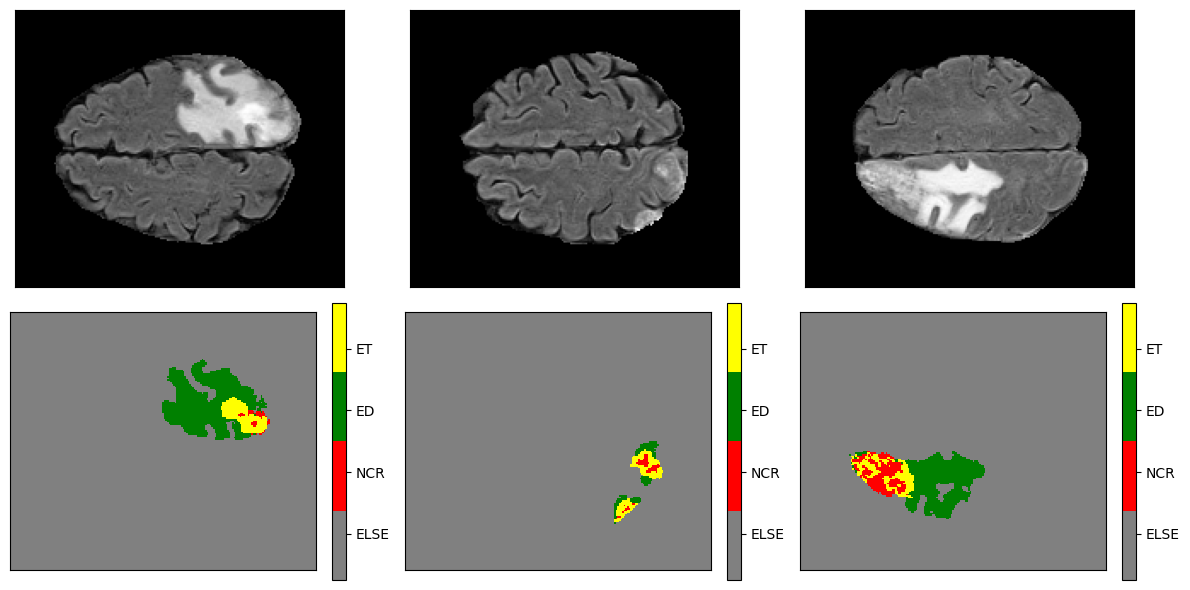

In [41]:
# depth plot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

# depth - base image
mri_plt.plot_struct_img(img_data=train_base[:, :, depth_file_no], fig=fig, axs=axs, row=0, col=0, colorbar=False)
mri_plt.plot_struct_img(img_data=val_base[:, :, depth_file_no], fig=fig, axs=axs, row=0, col=1, colorbar=False)
mri_plt.plot_struct_img(img_data=test_base[:, :, depth_file_no], fig=fig, axs=axs, row=0, col=2, colorbar=False)

# depth - segmentation
mri_plt.plot_segm_img(img_data=train_depth_img, fig=fig, axs=axs, row=1, col=0)
mri_plt.plot_segm_img(img_data=val_depth_img, fig=fig, axs=axs, row=1, col=1)
mri_plt.plot_segm_img(img_data=test_depth_img, fig=fig, axs=axs, row=1, col=2)
plt.tight_layout()
plt.show()

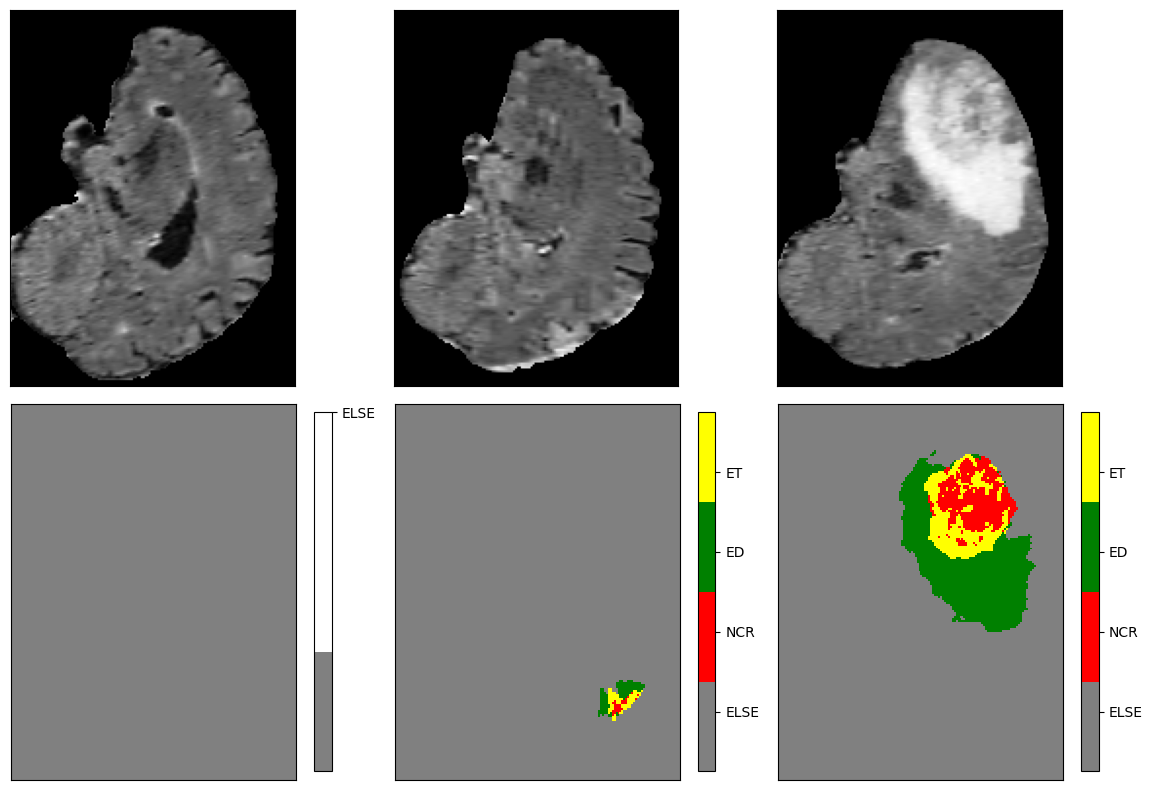

In [42]:
# cross side plot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
# cross side - base image
mri_plt.plot_struct_img(img_data=train_base[cross_side_file_no, :, :], fig=fig, axs=axs, row=0, col=0, colorbar=False)
mri_plt.plot_struct_img(img_data=val_base[cross_side_file_no, :, :], fig=fig, axs=axs, row=0, col=1, colorbar=False)
mri_plt.plot_struct_img(img_data=test_base[cross_side_file_no, :, :], fig=fig, axs=axs, row=0, col=2, colorbar=False)

# cross side - segmentation
mri_plt.plot_segm_img(img_data=train_cross_side_img, fig=fig, axs=axs, row=1, col=0)
mri_plt.plot_segm_img(img_data=val_cross_side_img, fig=fig, axs=axs, row=1, col=1)
mri_plt.plot_segm_img(img_data=test_cross_side_img, fig=fig, axs=axs, row=1, col=2,)

plt.tight_layout()
plt.show()

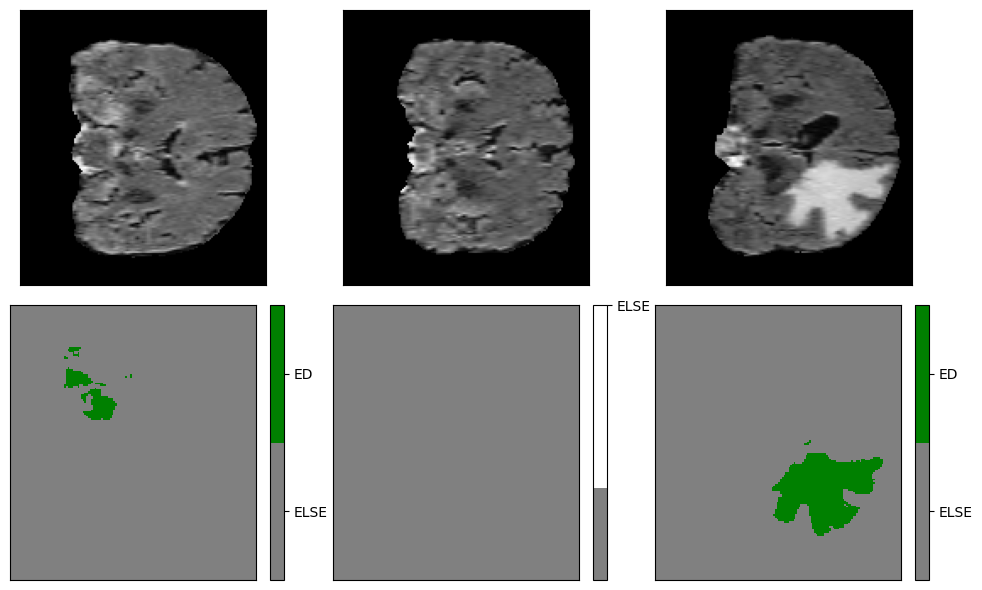

In [43]:
# cross front plot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# cross front - base image
mri_plt.plot_struct_img(img_data=train_base[:, cross_front_file_no, :], fig=fig, axs=axs, row=0, col=0, colorbar=False)
mri_plt.plot_struct_img(img_data=val_base[:, cross_front_file_no, :], fig=fig, axs=axs, row=0, col=1, colorbar=False)
mri_plt.plot_struct_img(img_data=test_base[:, cross_front_file_no, :], fig=fig, axs=axs, row=0, col=2, colorbar=False)

# cross front - segmentation
mri_plt.plot_segm_img(img_data=train_cross_front_img, fig=fig, axs=axs, row=1, col=0)
mri_plt.plot_segm_img(img_data=val_cross_front_img, fig=fig, axs=axs, row=1, col=1)
mri_plt.plot_segm_img(img_data=test_cross_front_img, fig=fig, axs=axs, row=1, col=2)

plt.tight_layout()
plt.show()